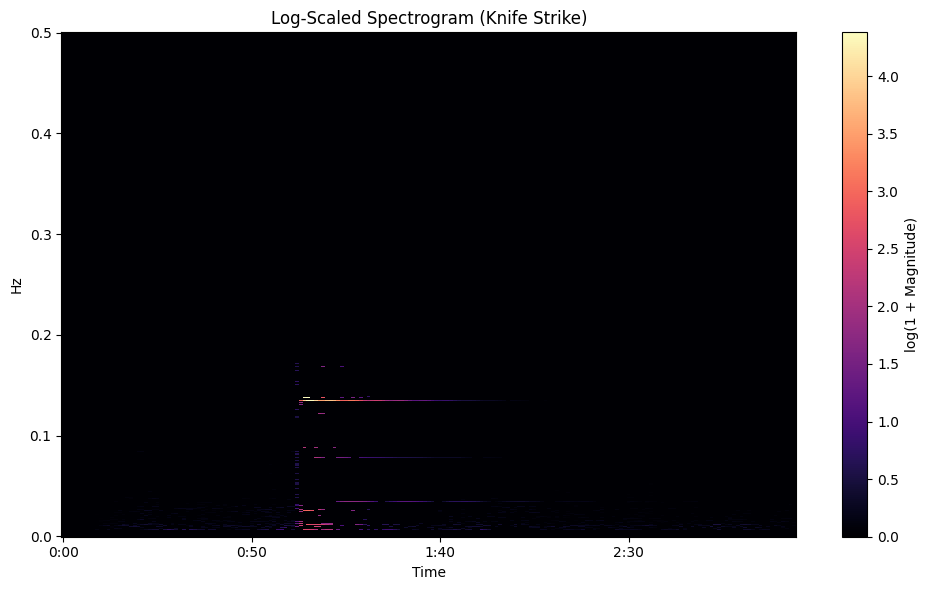

In [247]:
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import numpy as np

# Load CSV file
df = pd.read_csv("data/top.csv")  # or "bottom.csv"

# Extract the frequency and time axes
frequencies = df.iloc[:, 0].values      # First column: frequencies (Hz)
times = df.columns[1:].astype(float)    # Header row: time (ms)
matrix = df.iloc[:, 1:].values          # Magnitude values


# Logarithmic scaling to reveal structure
log_matrix = np.log1p(matrix)

# Plot
plt.figure(figsize=(10, 6))
librosa.display.specshow(
    log_matrix,
    x_axis='time',
    y_axis='hz',
    sr=1,            # dummy value; we're not using actual sample rate
    hop_length=1,    # fake hop length just to avoid warning
    cmap='magma'
)
plt.title("Log-Scaled Spectrogram (Knife Strike)")
plt.colorbar(label="log(1 + Magnitude)")
plt.tight_layout()
plt.show()


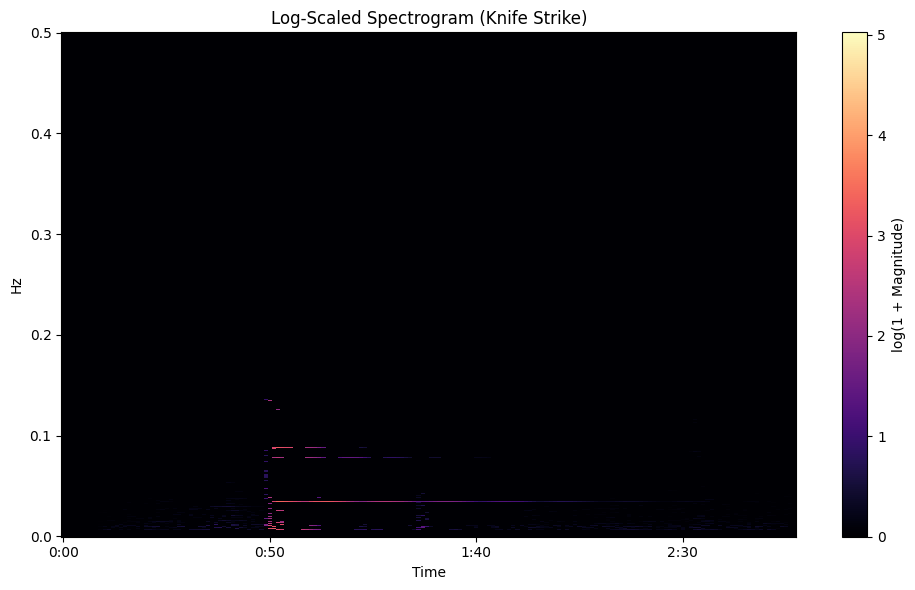

In [248]:
# Load CSV file
df = pd.read_csv("data/bottom.csv")  # or "bottom.csv"

# Extract the frequency and time axes
frequencies = df.iloc[:, 0].values      # First column: frequencies (Hz)
times = df.columns[1:].astype(float)    # Header row: time (ms)
matrix = df.iloc[:, 1:].values          # Magnitude values


# Logarithmic scaling to reveal structure
log_matrix = np.log1p(matrix)

# Plot
plt.figure(figsize=(10, 6))
librosa.display.specshow(
    log_matrix,
    x_axis='time',
    y_axis='hz',
    sr=1,            # dummy value; we're not using actual sample rate
    hop_length=1,    # fake hop length just to avoid warning
    cmap='magma'
)
plt.title("Log-Scaled Spectrogram (Knife Strike)")
plt.colorbar(label="log(1 + Magnitude)")
plt.tight_layout()
plt.show()


In [250]:
import os
import pandas as pd
import numpy as np

def longest_streak_with_freq(log_matrix: np.ndarray, freqs: np.ndarray, threshold: float):
    """Return (longest_streak_length, corresponding_frequency)"""
    max_streak = 0
    dominant_freq = 0.0

    for i, row in enumerate(log_matrix):
        current = longest = 0
        for val in row:
            if val > threshold:
                current += 1
                longest = max(longest, current)
            else:
                current = 0
        if longest > max_streak:
            max_streak = longest
            dominant_freq = freqs[i]

    return max_streak, dominant_freq

def classify_by_longest_bright_band(fpath: str,
                                    threshold: float = 0.7,
                                    freq_cutoff: float = 800) -> (float, int):
    """
    Returns:
      dominant_freq (Hz), label
      label: 0 if dominant_freq >= freq_cutoff (TOP)
             1 if dominant_freq <  freq_cutoff (BOTTOM)
    """
    df = pd.read_csv(fpath)
    freqs  = df.iloc[:,   0].values
    matrix = df.iloc[:,1:].values
    log_m  = np.log1p(matrix)

    streak, dominant_freq = longest_streak_with_freq(log_m, freqs, threshold)

    # classify purely by frequency
    label = 1 if dominant_freq < freq_cutoff else 0

    return dominant_freq, label

def main():
    folder = "data"
    print(f"Classifying files in: {folder}\n")
    for fname in os.listdir(folder):
        if not fname.endswith(".csv"):
            continue
        path = os.path.join(folder, fname)
        try:
            dom_freq, cls = classify_by_longest_bright_band(path)
            label_str = "TOP" if cls == 0 else "BOTTOM"
            print(f"{fname:15s} → {dom_freq:6.3f} Hz  classified as {label_str}")
        except Exception as e:
            print(f"{fname}: ERROR - {e}")

if __name__ == "__main__":
    main()


Classifying files in: data

unlabeled_23.csv → 764.429 Hz  classified as BOTTOM
unlabeled_37.csv → 1065.894 Hz  classified as TOP
unlabeled_22.csv → 764.429 Hz  classified as BOTTOM
unlabeled_26.csv → 764.429 Hz  classified as BOTTOM
unlabeled_27.csv → 764.429 Hz  classified as BOTTOM
unlabeled_31.csv → 764.429 Hz  classified as BOTTOM
unlabeled_25.csv → 764.429 Hz  classified as BOTTOM
unlabeled_95.csv → 2971.582 Hz  classified as TOP
unlabeled_42.csv → 2971.582 Hz  classified as TOP
unlabeled_56.csv → 1065.894 Hz  classified as TOP
top.csv         → 2971.582 Hz  classified as TOP
unlabeled_68.csv → 764.429 Hz  classified as BOTTOM
unlabeled_45.csv → 2971.582 Hz  classified as TOP
unlabeled_86.csv → 1065.894 Hz  classified as TOP
unlabeled_78.csv → 1065.894 Hz  classified as TOP
unlabeled_85.csv → 1065.894 Hz  classified as TOP
unlabeled_88.csv → 2960.815 Hz  classified as TOP
bottom.csv      → 764.429 Hz  classified as BOTTOM
unlabeled_61.csv → 764.429 Hz  classified as BOTTOM
unlabe

In [237]:
def extract_features(fpath: str) -> np.ndarray:
    import pandas as pd
    import numpy as np

    df = pd.read_csv(fpath)
    freqs = df.iloc[:, 0].values
    matrix = df.iloc[:, 1:].values
    times = df.columns[1:].astype(float).values

    log_matrix = np.log1p(matrix)

    # Avoid divide-by-zero
    denom = matrix.sum(axis=0)
    denom = np.where(denom == 0, 1e-8, denom)

    # Spectral Centroid
    centroid = (freqs[:, None] * matrix).sum(axis=0) / denom
    centroid = np.nan_to_num(centroid)
    centroid_mean = np.mean(centroid)

    # Bandwidth (spread around centroid)
    spread = ((freqs[:, None] - centroid_mean) ** 2 * matrix).sum(axis=0) / denom
    spread = np.nan_to_num(spread)
    bandwidth_mean = np.sqrt(np.mean(spread))

    # Rolloff 85%
    energy_per_time = matrix.sum(axis=0)
    cumsum = np.cumsum(matrix, axis=0)
    rolloff_idx = (cumsum >= 0.85 * energy_per_time).argmax(axis=0)
    rolloff_85 = np.nanmean(freqs[rolloff_idx])

    # Peak frequency (overall energy-wise)
    freq_energy = matrix.sum(axis=1)
    peak_freq = freqs[np.argmax(freq_energy)]


    return np.array([
        centroid_mean,
        bandwidth_mean,
        rolloff_85,
        peak_freq,
    ])


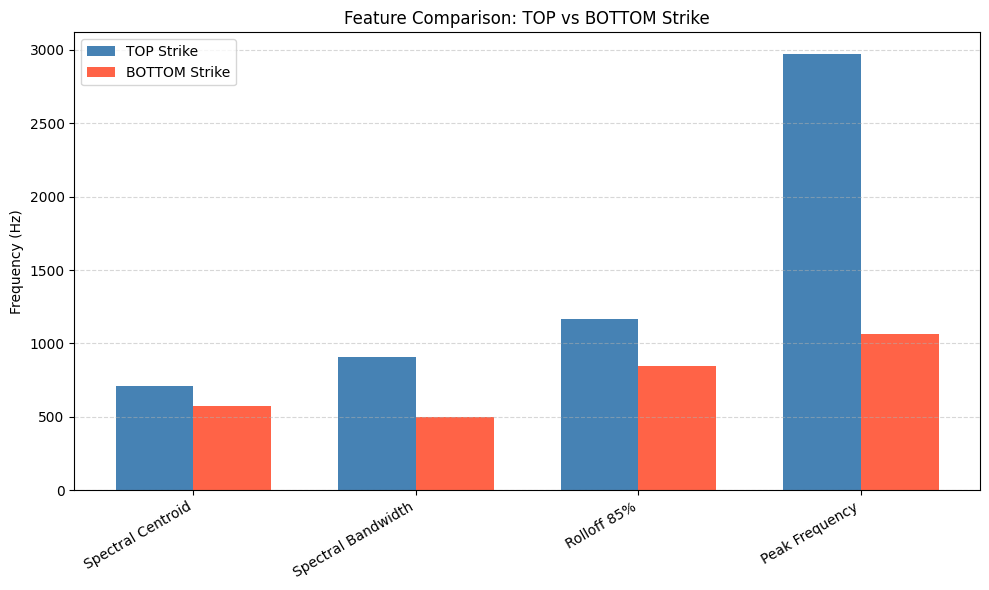

In [238]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Paths to your labeled files
top_path = "data/top.csv"
bottom_path = "data/bottom.csv"

# Extract feature vectors
top_vec = extract_features(top_path)
bottom_vec = extract_features(bottom_path)

# Feature names and shared unit (Hz)
feature_names = [
    "Spectral Centroid",
    "Spectral Bandwidth",
    "Rolloff 85%",
    "Peak Frequency",
]

x = np.arange(len(feature_names))
width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, top_vec, width, label='TOP Strike', color='steelblue')
ax.bar(x + width/2, bottom_vec, width, label='BOTTOM Strike', color='tomato')

ax.set_ylabel("Frequency (Hz)")
ax.set_title("Feature Comparison: TOP vs BOTTOM Strike")
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=30, ha='right')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [239]:
from sklearn.metrics.pairwise import cosine_similarity

def classify_vector(vec, top_vec, bottom_vec):
    sim_top = cosine_similarity([vec], [top_vec])[0][0]
    sim_bottom = cosine_similarity([vec], [bottom_vec])[0][0]
    print(f"[DEBUG] Cosine similarity → Top: {sim_top:.3f}, Bottom: {sim_bottom:.3f}")
    
    if abs(sim_top - sim_bottom) < 0.05:
        return None
    return 0 if sim_top > sim_bottom else 1


In [240]:
def classify_all(folder="data"):
    top_vec = extract_features(os.path.join(folder, "top.csv"))
    bottom_vec = extract_features(os.path.join(folder, "bottom.csv"))

    for fname in os.listdir(folder):
        if fname.endswith(".csv") and not fname.startswith(("top", "bottom")):
            fpath = os.path.join(folder, fname)
            try:
                vec = extract_features(fpath)
                result = classify_vector(vec, top_vec, bottom_vec)
                label = {0: "top", 1: "bottom", None: "unsure"}[result]
                print(f"{fname}: {label.upper()}")
            except Exception as e:
                print(f"{fname}: ERROR - {e}")


In [241]:
import os

def cosine_sim_with_base_vector():
    folder = "data"
    print(f"\n[INFO] Extracting feature vectors from labeled examples...\n")

    # Load labeled feature vectors
    top_path = os.path.join(folder, "top.csv")
    bottom_path = os.path.join(folder, "bottom.csv")
    
    top_vec = extract_features(top_path)
    bottom_vec = extract_features(bottom_path)
    
    results = []  # Store (filename, label)

    # Self-verification: classify the known samples against each other
    print("\n[CHECK] Verifying known labeled data...\n")

    predicted_top = classify_vector(top_vec, top_vec, bottom_vec)
    predicted_bottom = classify_vector(bottom_vec, top_vec, bottom_vec)

    if predicted_top != 0:
        print("[WARNING] top.csv was NOT classified as TOP ❌")
    else:
        print("[PASS] top.csv correctly classified as TOP ✅")

    if predicted_bottom != 1:
        print("[WARNING] bottom.csv was NOT classified as BOTTOM ❌")
    else:
        print("[PASS] bottom.csv correctly classified as BOTTOM ✅")

    print(f"\n[INFO] Classifying unlabeled files in folder: {folder}\n")

    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".csv") and not fname.startswith(("top", "bottom")):
            fpath = os.path.join(folder, fname)
            try:
                unlabeled_vec = extract_features(fpath)
                result = classify_vector(unlabeled_vec, top_vec, bottom_vec)
                label = {0: "top", 1: "bottom", None: "unsure"}[result]
                print(f"{fname}: {label.upper()}")
                results.append((fname, label))
            except Exception as e:
                print(f"{fname}: ERROR - {e}")
                results.append((fname, "error"))

    return results  # Optional: return results if calling from another script


if __name__ == "__main__":
    main()


Classifying files in: data


[DEBUG] Processing: data/unlabeled_23.csv
[DEBUG] Longest streak: 26 timepoints at 764.4287 Hz
[DEBUG] Classified as: top (0)
Result → unlabeled_23.csv: TOP

[DEBUG] Processing: data/unlabeled_37.csv
[DEBUG] Longest streak: 35 timepoints at 1065.8936 Hz
[DEBUG] Classified as: top (0)
Result → unlabeled_37.csv: TOP

[DEBUG] Processing: data/unlabeled_22.csv
[DEBUG] Longest streak: 37 timepoints at 764.4287 Hz
[DEBUG] Classified as: top (0)
Result → unlabeled_22.csv: TOP

[DEBUG] Processing: data/unlabeled_26.csv
[DEBUG] Longest streak: 64 timepoints at 764.4287 Hz
[DEBUG] Classified as: top (0)
Result → unlabeled_26.csv: TOP

[DEBUG] Processing: data/unlabeled_27.csv
[DEBUG] Longest streak: 49 timepoints at 764.4287 Hz
[DEBUG] Classified as: top (0)
Result → unlabeled_27.csv: TOP

[DEBUG] Processing: data/unlabeled_31.csv
[DEBUG] Longest streak: 61 timepoints at 764.4287 Hz
[DEBUG] Classified as: top (0)
Result → unlabeled_31.csv: TOP

[DEBUG] Processing: da

In [242]:
import os
from sklearn.metrics.pairwise import cosine_similarity

def update_average_vector(current_avg, new_vec, count):
    return (current_avg * count + new_vec) / (count + 1)

def cosine_sim_with_updated_base_vector():
    folder = "data"
    print(f"\n[INFO] Extracting feature vectors from labeled examples...\n")

    # Load labeled feature vectors
    top_path = os.path.join(folder, "top.csv")
    bottom_path = os.path.join(folder, "bottom.csv")

    top_vec = extract_features(top_path)
    bottom_vec = extract_features(bottom_path)
    top_count, bottom_count = 1, 1  # initial count from labeled files

    results = []  # Store (filename, label)

    print("\n[CHECK] Verifying known labeled data...\n")

    predicted_top = classify_vector(top_vec, top_vec, bottom_vec)
    predicted_bottom = classify_vector(bottom_vec, top_vec, bottom_vec)

    if predicted_top != 0:
        print("[WARNING] top.csv was NOT classified as TOP ❌")
    else:
        print("[PASS] top.csv correctly classified as TOP ✅")

    if predicted_bottom != 1:
        print("[WARNING] bottom.csv was NOT classified as BOTTOM ❌")
    else:
        print("[PASS] bottom.csv correctly classified as BOTTOM ✅")

    print(f"\n[INFO] Classifying unlabeled files in folder: {folder}\n")

    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".csv") and not fname.startswith(("top", "bottom")):
            fpath = os.path.join(folder, fname)
            try:
                vec = extract_features(fpath)
                sim_top = cosine_similarity([vec], [top_vec])[0][0]
                sim_bottom = cosine_similarity([vec], [bottom_vec])[0][0]
                diff = abs(sim_top - sim_bottom)

                print(f"[DEBUG] {fname} → Top Sim: {sim_top:.3f}, Bottom Sim: {sim_bottom:.3f}")

                if diff < 0.05:
                    results.append((fname, "unsure"))
                    print(f"{fname}: UNSURE")
                    continue

                if sim_top > sim_bottom:
                    top_vec = update_average_vector(top_vec, vec, top_count)
                    top_count += 1
                    results.append((fname, "top"))
                    print(f"{fname}: TOP")
                else:
                    bottom_vec = update_average_vector(bottom_vec, vec, bottom_count)
                    bottom_count += 1
                    results.append((fname, "bottom"))
                    print(f"{fname}: BOTTOM")

            except Exception as e:
                print(f"{fname}: ERROR - {e}")
                results.append((fname, "error"))

    return results  # Return for external comparison


In [217]:
def compare_classifications(results1, results2):
    assert len(results1) == len(results2), "Lists must be the same length"

    total = len(results1)
    matches = 0

    for (f1, label1), (f2, label2) in zip(results1, results2):
        assert f1 == f2, f"Filenames don't match: {f1} vs {f2}"
        if label1 == label2:
            matches += 1
        else:
            print(f"[MISMATCH] {f1}: {label1.upper()} vs {label2.upper()}")

    accuracy = matches / total
    print(f"\n[COMPARE] Agreement: {matches}/{total} = {accuracy:.2%}")


In [218]:
results1 = cosine_sim_with_base_vector()
results2 = cosine_sim_with_updated_base_vector()
compare_classifications(results1,results2)


[INFO] Extracting feature vectors from labeled examples...


[CHECK] Verifying known labeled data...

[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.948
[DEBUG] Cosine similarity → Top: 0.948, Bottom: 1.000
[PASS] top.csv correctly classified as TOP ✅
[PASS] bottom.csv correctly classified as BOTTOM ✅

[INFO] Classifying unlabeled files in folder: data

[DEBUG] Cosine similarity → Top: 0.883, Bottom: 0.982
unlabeled_00.csv: BOTTOM
[DEBUG] Cosine similarity → Top: 0.950, Bottom: 0.999
unlabeled_10.csv: UNSURE
[DEBUG] Cosine similarity → Top: 0.911, Bottom: 0.989
unlabeled_15.csv: BOTTOM
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.950
unlabeled_22.csv: TOP
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.952
unlabeled_23.csv: UNSURE
[DEBUG] Cosine similarity → Top: 0.923, Bottom: 0.997
unlabeled_25.csv: BOTTOM
[DEBUG] Cosine similarity → Top: 0.939, Bottom: 0.999
unlabeled_26.csv: BOTTOM
[DEBUG] Cosine similarity → Top: 0.996, Bottom: 0.969
unlabeled_27.csv: UNSURE
[DEBUG] Cos

In [219]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_feature_vectors(vectors, labels, method="pca"):
    X = np.vstack(vectors)
    y = np.array(labels)

    if method == "pca":
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2, perplexity=10)

    X_reduced = reducer.fit_transform(X)

    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        idx = y == label
        plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], label=label, alpha=0.7)

    plt.legend()
    plt.title(f"Feature Space Visualized via {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [220]:
def extract_all_features(folder="data"):
    vectors = []
    labels = []
    filenames = []

    top_vec = extract_features(os.path.join(folder, "top.csv"))
    bottom_vec = extract_features(os.path.join(folder, "bottom.csv"))

    # Include labeled examples
    vectors.append(top_vec)
    labels.append("top")
    filenames.append("top.csv")

    vectors.append(bottom_vec)
    labels.append("bottom")
    filenames.append("bottom.csv")

    # Classify and collect unlabeled
    for fname in os.listdir(folder):
        if fname.endswith(".csv") and not fname.startswith(("top", "bottom")):
            fpath = os.path.join(folder, fname)
            try:
                vec = extract_features(fpath)
                result = classify_vector(vec, top_vec, bottom_vec)
                label = {0: "top", 1: "bottom", None: "unsure"}[result]
                vectors.append(vec)
                labels.append(label)
                filenames.append(fname)
            except Exception as e:
                print(f"[ERROR] {fname}: {e}")

    return np.array(vectors), labels, filenames


In [221]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def visualize_with_pca_tsne(vectors, labels):
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(vectors)

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vectors_scaled)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=5, init='pca')
    tsne_result = tsne.fit_transform(vectors_scaled)

    def plot_2d(points, title):
        plt.figure(figsize=(8, 6))
        for label in set(labels):
            mask = np.array(labels) == label
            plt.scatter(points[mask, 0], points[mask, 1], label=label.upper(), alpha=0.7)
        plt.title(title)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plot_2d(pca_result, "PCA Projection of Strike Features")
    plot_2d(tsne_result, "t-SNE Projection of Strike Features")

[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.952
[DEBUG] Cosine similarity → Top: 0.914, Bottom: 0.994
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.950
[DEBUG] Cosine similarity → Top: 0.939, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.996, Bottom: 0.969
[DEBUG] Cosine similarity → Top: 0.935, Bottom: 0.998
[DEBUG] Cosine similarity → Top: 0.923, Bottom: 0.997
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.954
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.957, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.891, Bottom: 0.983
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.962
[DEBUG] Cosine similarity → Top: 0.864, Bottom: 0.976
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.936, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.944
[DEBUG] Cosine similarity → Top: 0.953, Bottom: 1.000
[DEBUG] Cosine similarity → Top: 0.932, Bottom: 0.996
[DEBUG] Cosine similarity → 

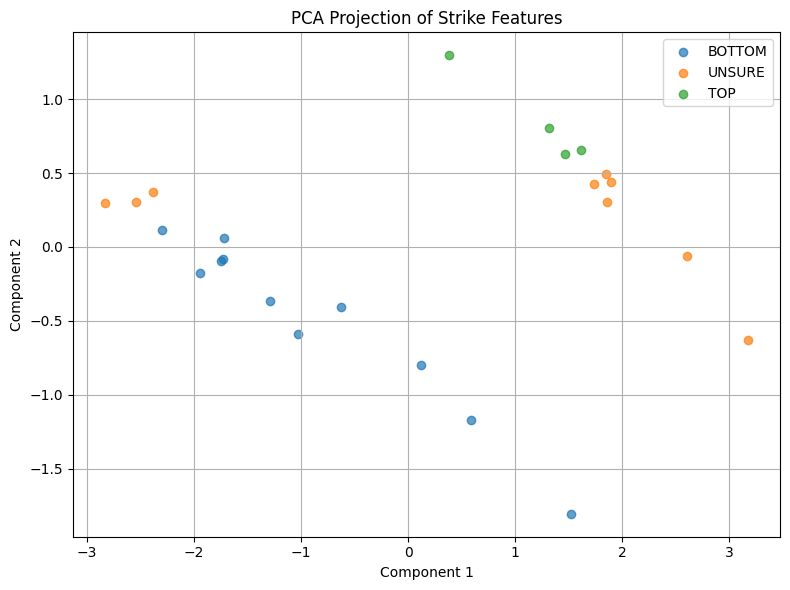

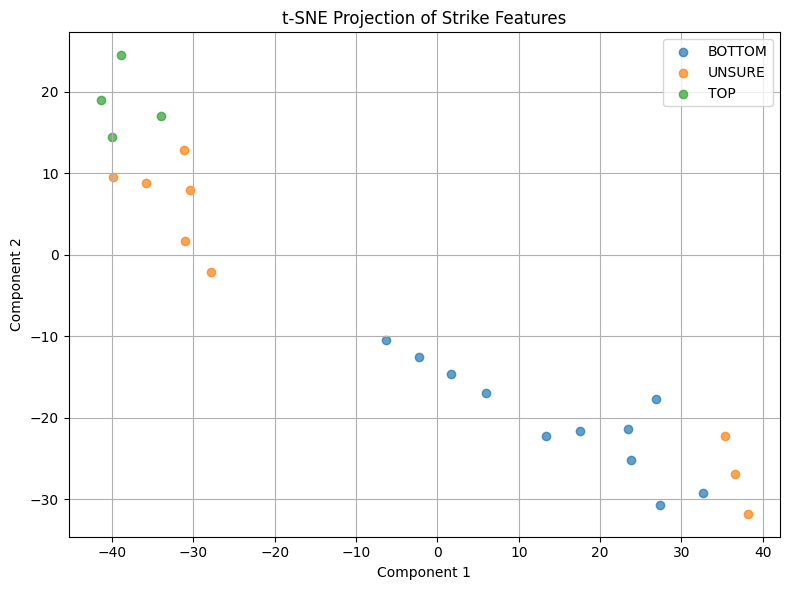

In [222]:
vectors, labels, filenames = extract_all_features("data")
visualize_with_pca_tsne(vectors, np.array(labels))

In [223]:
from sklearn.cluster import KMeans

features, _, files = extract_all_features("data")
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(features)

top_idx = files.index("top.csv")
bottom_idx = files.index("bottom.csv")

# Find cluster assignment
cluster_for_top = cluster_labels[top_idx]
cluster_for_bottom = cluster_labels[bottom_idx]

label_map = {}
label_map[cluster_for_top] = "top"
label_map[cluster_for_bottom] = "bottom"

for fname, cluster in zip(files, cluster_labels):
    predicted = label_map.get(cluster, "unknown")
    print(f"{fname}: {predicted.upper()}")


[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.952
[DEBUG] Cosine similarity → Top: 0.914, Bottom: 0.994
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.950
[DEBUG] Cosine similarity → Top: 0.939, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.996, Bottom: 0.969
[DEBUG] Cosine similarity → Top: 0.935, Bottom: 0.998
[DEBUG] Cosine similarity → Top: 0.923, Bottom: 0.997
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.954
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.957, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.891, Bottom: 0.983
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.962
[DEBUG] Cosine similarity → Top: 0.864, Bottom: 0.976
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.936, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.944
[DEBUG] Cosine similarity → Top: 0.953, Bottom: 1.000
[DEBUG] Cosine similarity → Top: 0.932, Bottom: 0.996
[DEBUG] Cosine similarity → 

[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.952
[DEBUG] Cosine similarity → Top: 0.914, Bottom: 0.994
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.950
[DEBUG] Cosine similarity → Top: 0.939, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.996, Bottom: 0.969
[DEBUG] Cosine similarity → Top: 0.935, Bottom: 0.998
[DEBUG] Cosine similarity → Top: 0.923, Bottom: 0.997
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.954
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.957, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.891, Bottom: 0.983
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.962
[DEBUG] Cosine similarity → Top: 0.864, Bottom: 0.976
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.936, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.944
[DEBUG] Cosine similarity → Top: 0.953, Bottom: 1.000
[DEBUG] Cosine similarity → Top: 0.932, Bottom: 0.996
[DEBUG] Cosine similarity → 

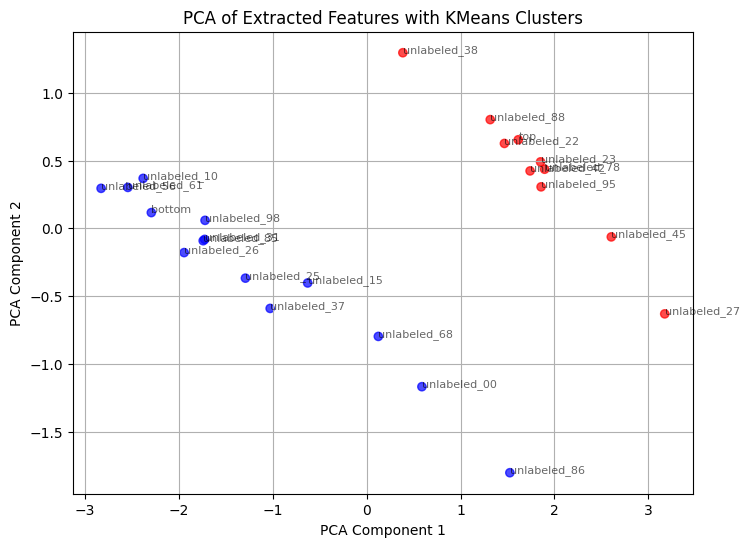

In [224]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Extract features and filenames
features, _, files = extract_all_features("data")

# Run KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(features)

scaler = StandardScaler()
vectors_scaled = scaler.fit_transform(features)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors_scaled)

# Map clusters to labels
top_idx = files.index("top.csv")
bottom_idx = files.index("bottom.csv")
cluster_for_top = cluster_labels[top_idx]
cluster_for_bottom = cluster_labels[bottom_idx]
label_map = {cluster_for_top: "top", cluster_for_bottom: "bottom"}

# Plot
colors = ['red' if label_map[cluster] == 'top' else 'blue' for cluster in cluster_labels]

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=colors, alpha=0.7)

# Annotate points with filenames
for i, fname in enumerate(files):
    plt.annotate(fname.replace(".csv", ""), (reduced[i, 0], reduced[i, 1]), fontsize=8, alpha=0.6)

plt.title("PCA of Extracted Features with KMeans Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.952
[DEBUG] Cosine similarity → Top: 0.914, Bottom: 0.994
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.950
[DEBUG] Cosine similarity → Top: 0.939, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.996, Bottom: 0.969
[DEBUG] Cosine similarity → Top: 0.935, Bottom: 0.998
[DEBUG] Cosine similarity → Top: 0.923, Bottom: 0.997
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.954
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.957, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.891, Bottom: 0.983
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.962
[DEBUG] Cosine similarity → Top: 0.864, Bottom: 0.976
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.936, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.944
[DEBUG] Cosine similarity → Top: 0.953, Bottom: 1.000
[DEBUG] Cosine similarity → Top: 0.932, Bottom: 0.996
[DEBUG] Cosine similarity → 

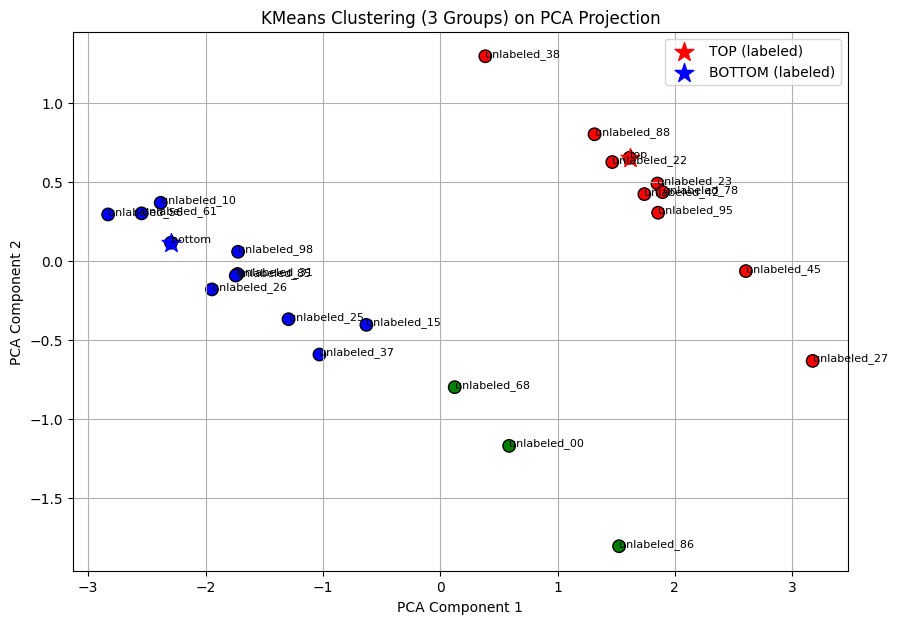

In [225]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Step 1: Extract features and filenames
features, _, files = extract_all_features("data")

# Step 2: KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels = kmeans.fit_predict(features)

scaler = StandardScaler()
vectors_scaled = scaler.fit_transform(features)

# Step 3: PCA for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors_scaled)

# Step 4: Assign cluster colors
colors = ['red', 'blue', 'green']
point_colors = [colors[label] for label in cluster_labels]

# Step 5: Plotting
plt.figure(figsize=(10, 7))
plt.scatter(reduced[:, 0], reduced[:, 1], c=point_colors, edgecolor='k', s=80)

# Highlight labeled files
top_idx = files.index("top.csv")
bottom_idx = files.index("bottom.csv")

plt.scatter(reduced[top_idx, 0], reduced[top_idx, 1], c='red', s=200, marker='*', label='TOP (labeled)')
plt.scatter(reduced[bottom_idx, 0], reduced[bottom_idx, 1], c='blue', s=200, marker='*', label='BOTTOM (labeled)')

# Annotate points
for i, fname in enumerate(files):
    plt.annotate(fname.replace(".csv", ""), (reduced[i, 0], reduced[i, 1]), fontsize=8)

# Print counts per cluster
counts = Counter(cluster_labels)
print("Cluster counts:", counts)

plt.title("KMeans Clustering (3 Groups) on PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.952
[DEBUG] Cosine similarity → Top: 0.914, Bottom: 0.994
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.950
[DEBUG] Cosine similarity → Top: 0.939, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.996, Bottom: 0.969
[DEBUG] Cosine similarity → Top: 0.935, Bottom: 0.998
[DEBUG] Cosine similarity → Top: 0.923, Bottom: 0.997
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.954
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.957, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.891, Bottom: 0.983
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.962
[DEBUG] Cosine similarity → Top: 0.864, Bottom: 0.976
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.936, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.944
[DEBUG] Cosine similarity → Top: 0.953, Bottom: 1.000
[DEBUG] Cosine similarity → Top: 0.932, Bottom: 0.996
[DEBUG] Cosine similarity → 

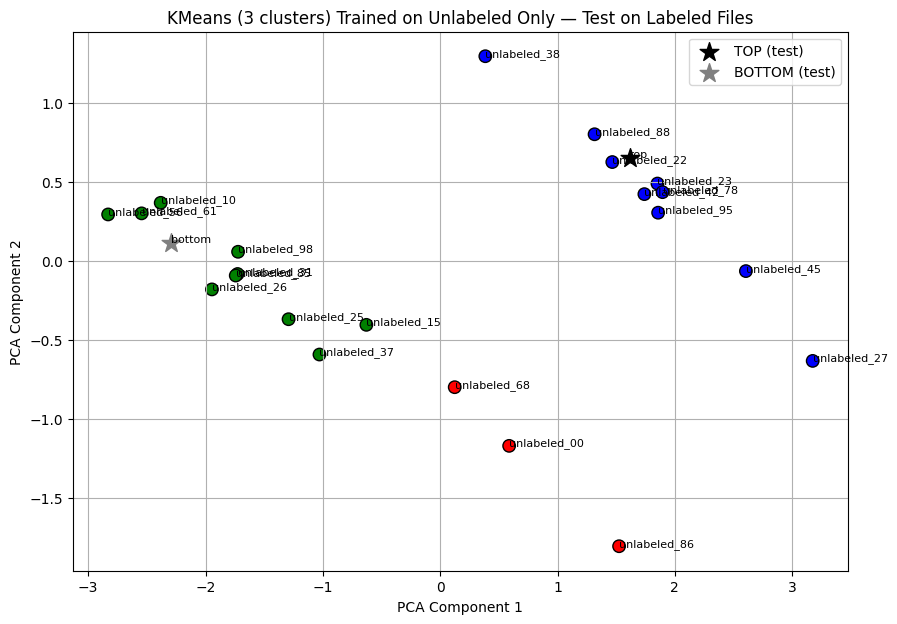

In [227]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter


# Step 1: Extract features, labels, and files
features, true_labels, files = extract_all_features("data")

# Step 2: Separate training and test sets
top_idx = files.index("top.csv")
bottom_idx = files.index("bottom.csv")
test_indices = [top_idx, bottom_idx]

X_test = features[test_indices]
y_test = [true_labels[i] for i in test_indices]

train_indices = [i for i in range(len(files)) if i not in test_indices]
X_train = features[train_indices]
train_files = [files[i] for i in train_indices]

# Step 3: Train KMeans on unlabeled data only
kmeans = KMeans(n_clusters=3, random_state=0)
train_cluster_labels = kmeans.fit_predict(X_train)

# Step 4: Assign cluster to test points
test_cluster_labels = kmeans.predict(X_test)

# Step 5: Map clusters to pseudo-labels based on majority vote
cluster_to_label = {}
for cluster in range(3):
    cluster_points = [i for i, label in enumerate(train_cluster_labels) if label == cluster]
    votes = [true_labels[train_indices[i]] for i in cluster_points if true_labels[train_indices[i]] != 'unsure']
    if votes:
        majority = Counter(votes).most_common(1)[0][0]
        cluster_to_label[cluster] = majority
    else:
        cluster_to_label[cluster] = "unknown"

# Step 6: Predicted labels
predicted_test_labels = [cluster_to_label[c] for c in test_cluster_labels]

# Step 7: Evaluation
print("True Labels:", y_test)
print("Predicted Labels:", predicted_test_labels)

scaler = StandardScaler()
vectors_scaled = scaler.fit_transform(vectors)

# Step 8: PCA for all points (train + test)
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors_scaled)

# Step 9: Plot
colors = ['red', 'blue', 'green']
point_colors = [colors[label] for label in train_cluster_labels]
reduced_train = reduced[train_indices]

plt.figure(figsize=(10, 7))
plt.scatter(reduced_train[:, 0], reduced_train[:, 1], c=point_colors, edgecolor='k', s=80)

# Plot test points
reduced_test = reduced[test_indices]
plt.scatter(reduced_test[0, 0], reduced_test[0, 1], c='black', s=200, marker='*', label='TOP (test)')
plt.scatter(reduced_test[1, 0], reduced_test[1, 1], c='gray', s=200, marker='*', label='BOTTOM (test)')

# Annotate all
for i, fname in enumerate(files):
    plt.annotate(fname.replace(".csv", ""), (reduced[i, 0], reduced[i, 1]), fontsize=8)

plt.title("KMeans (3 clusters) Trained on Unlabeled Only — Test on Labeled Files")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.952
[DEBUG] Cosine similarity → Top: 0.914, Bottom: 0.994
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.950
[DEBUG] Cosine similarity → Top: 0.939, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.996, Bottom: 0.969
[DEBUG] Cosine similarity → Top: 0.935, Bottom: 0.998
[DEBUG] Cosine similarity → Top: 0.923, Bottom: 0.997
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.954
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.957, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 0.891, Bottom: 0.983
[DEBUG] Cosine similarity → Top: 0.999, Bottom: 0.962
[DEBUG] Cosine similarity → Top: 0.864, Bottom: 0.976
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.953
[DEBUG] Cosine similarity → Top: 0.936, Bottom: 0.999
[DEBUG] Cosine similarity → Top: 1.000, Bottom: 0.944
[DEBUG] Cosine similarity → Top: 0.953, Bottom: 1.000
[DEBUG] Cosine similarity → Top: 0.932, Bottom: 0.996
[DEBUG] Cosine similarity → 

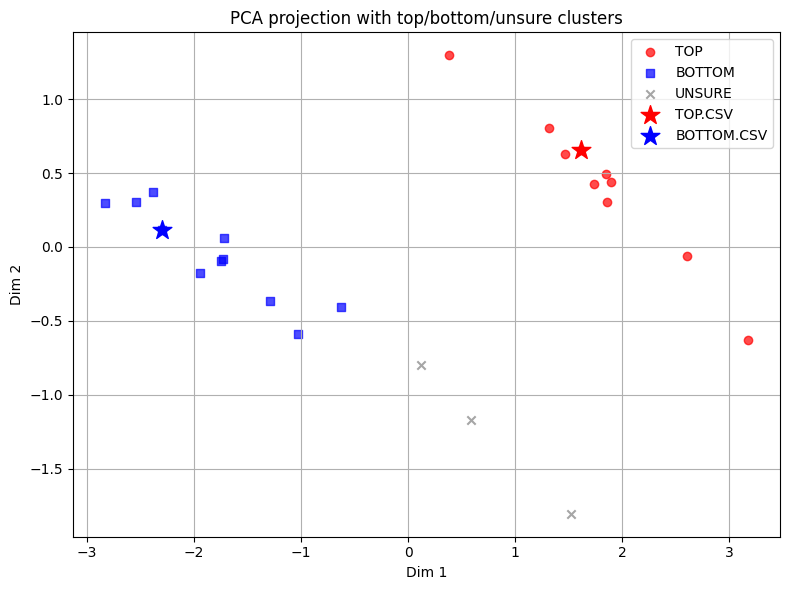

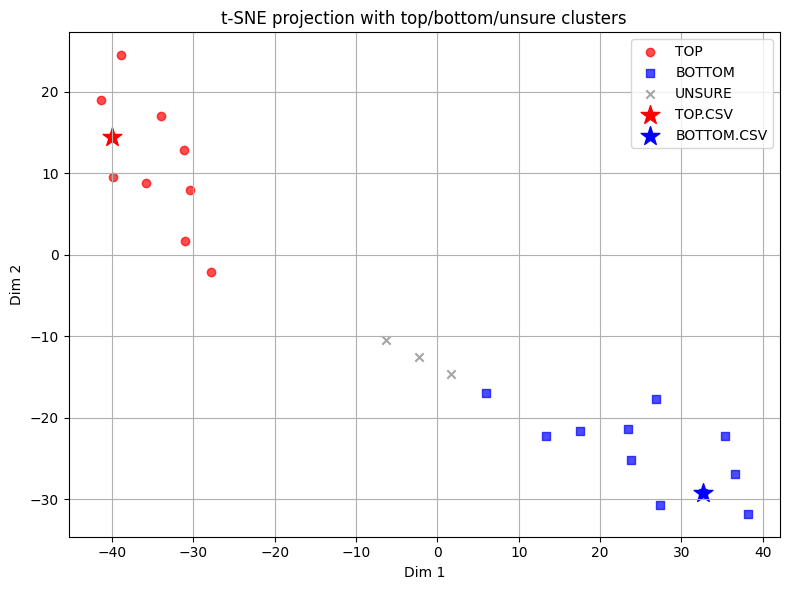

In [246]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler

# Step 1: Extract features, labels, and files
features, true_labels, files = extract_all_features("data")

# Step 2: Identify indices of labeled examples
top_idx = files.index("top.csv")
bottom_idx = files.index("bottom.csv")
test_indices = [top_idx, bottom_idx]

# Split train vs test
train_indices = [i for i in range(len(files)) if i not in test_indices]
X_train = features[train_indices]
X_test  = features[test_indices]
y_test  = [true_labels[i] for i in test_indices]

# Standardize all features
scaler = StandardScaler().fit(features)
features_scaled = scaler.transform(features)
X_train_scaled = features_scaled[train_indices]
X_test_scaled  = features_scaled[test_indices]

# Step 3: KMeans on unlabeled only (3 clusters)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_train_scaled)
train_labels = kmeans.labels_

# Step 4: Map clusters to top/bottom via labeled examples
cluster_map = {}
for label, idx in [("top", top_idx), ("bottom", bottom_idx)]:
    cluster = kmeans.predict([features_scaled[idx]])[0]
    cluster_map[cluster] = label

# Step 5: Predict for all files
pred_labels = []
for i, cluster in enumerate(kmeans.predict(features_scaled)):
    pred_labels.append(cluster_map.get(cluster, "unsure"))

# Step 6: PCA and t-SNE embeddings
pca_emb  = PCA(n_components=2).fit_transform(features_scaled)
tsne_emb = TSNE(n_components=2, random_state=42, perplexity=5, init='pca').fit_transform(features_scaled)

# Plot function
def plot_emb(emb, title):
     plt.figure(figsize=(8,6))
     for lbl, color, marker in [("top", 'red', 'o'), ("bottom", 'blue', 's'), ("unsure", 'gray', 'x')]:
         idxs = [i for i, p in enumerate(pred_labels) if p == lbl]
         plt.scatter(emb[idxs,0], emb[idxs,1], c=color, marker=marker, label=lbl.upper(), alpha=0.7)
     # highlight true labeled points
     plt.scatter(emb[top_idx,0], emb[top_idx,1], c='red', marker='*', s=200, label='TOP.CSV')
     plt.scatter(emb[bottom_idx,0], emb[bottom_idx,1], c='blue', marker='*', s=200, label='BOTTOM.CSV')
     plt.title(title)
     plt.xlabel('Dim 1')
     plt.ylabel('Dim 2')
     plt.legend()
     plt.grid(True)
     plt.tight_layout()
     plt.show()

# Step 7: Visualize
plot_emb(pca_emb,  "PCA projection with top/bottom/unsure clusters")
plot_emb(tsne_emb, "t-SNE projection with top/bottom/unsure clusters")


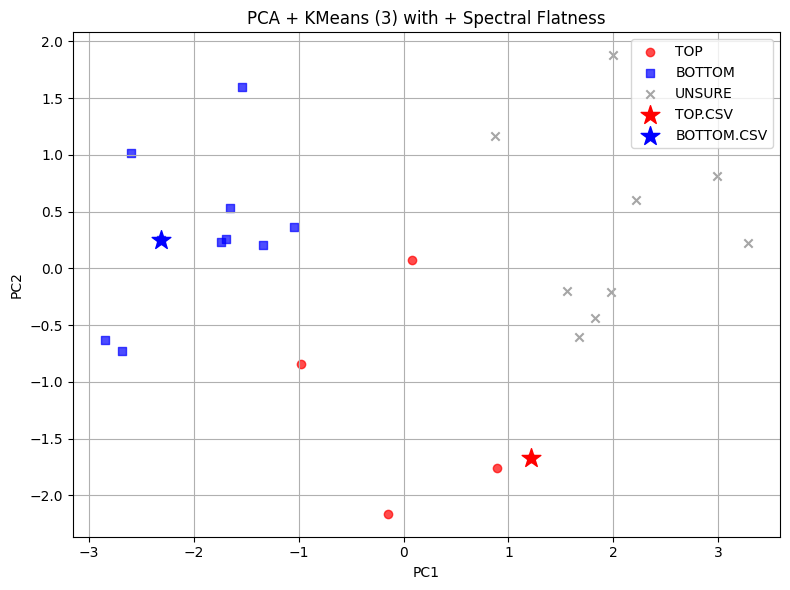

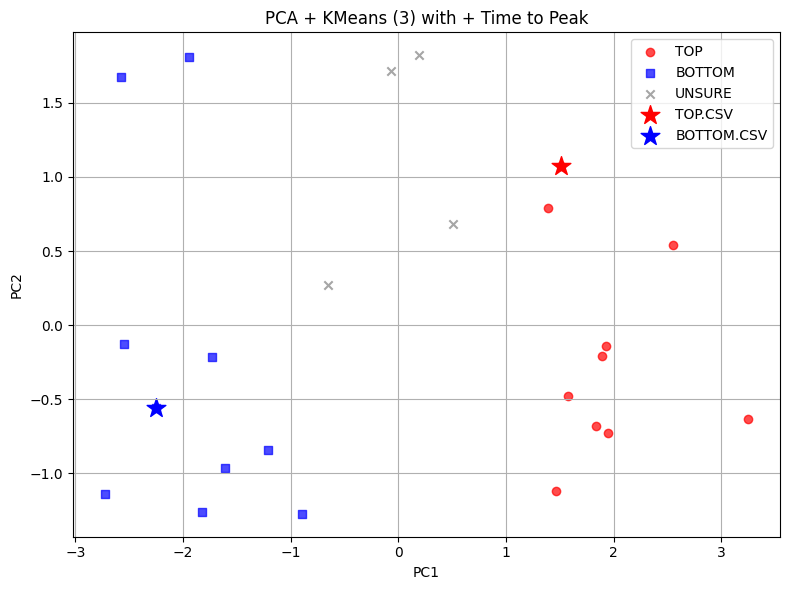

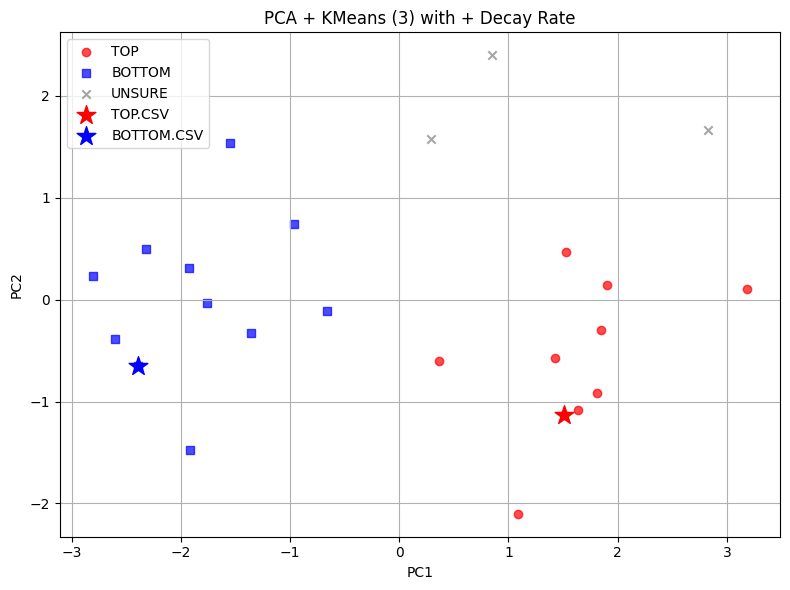

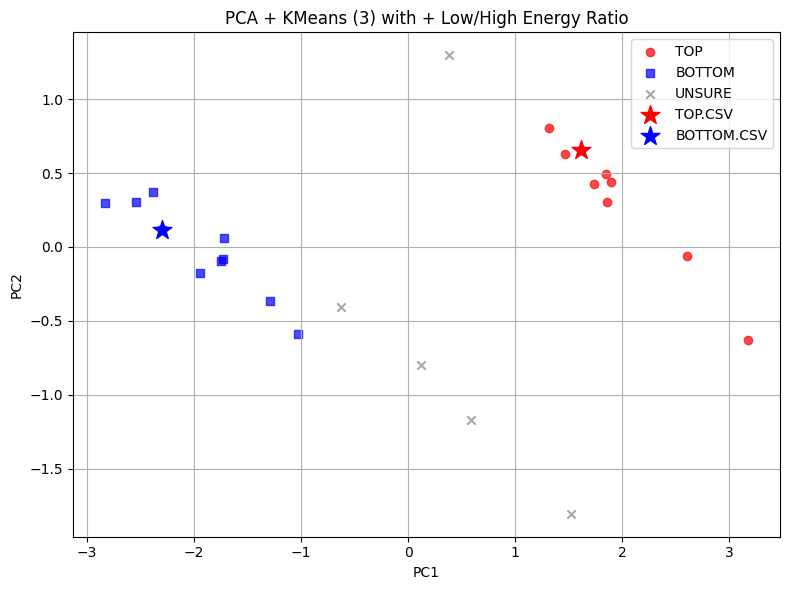

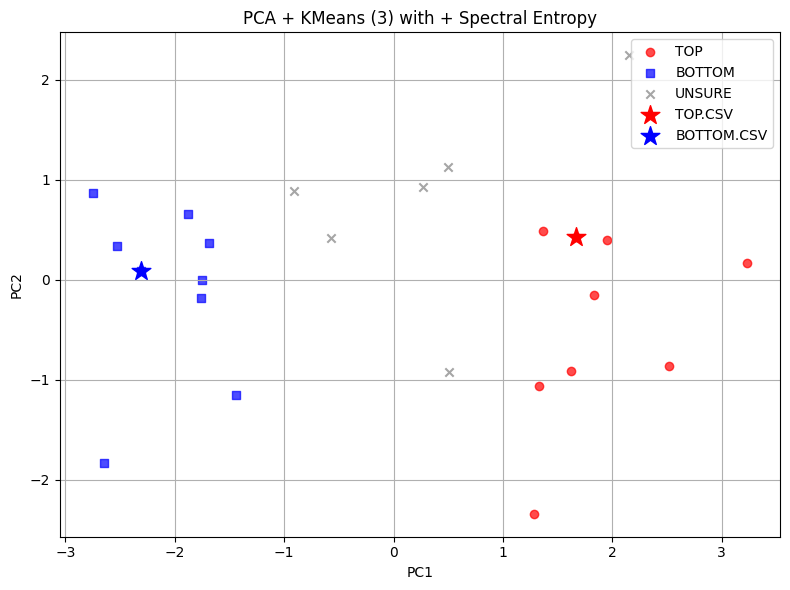

In [232]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gmean
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Directory containing your CSV files
data_dir = "data"
files = sorted(f for f in os.listdir(data_dir) if f.endswith(".csv"))

# --- Base Feature Extractor (4 features) ---
def extract_features_base(fpath):
    df = pd.read_csv(fpath)
    freqs = df.iloc[:, 0].values
    matrix = df.iloc[:, 1:].values

    denom = np.where(matrix.sum(axis=0) == 0, 1e-8, matrix.sum(axis=0))
    centroid = (freqs[:, None] * matrix).sum(axis=0) / denom
    centroid_mean = np.mean(centroid)

    spread = ((freqs[:, None] - centroid_mean)**2 * matrix).sum(axis=0) / denom
    bandwidth_mean = np.sqrt(np.mean(spread))

    energy_per_time = matrix.sum(axis=0)
    cumsum = np.cumsum(matrix, axis=0)
    rolloff_idx = (cumsum >= 0.85 * energy_per_time).argmax(axis=0)
    rolloff_85 = np.mean(freqs[rolloff_idx])

    peak_freq = freqs[np.argmax(matrix.sum(axis=1))]

    return np.array([centroid_mean, bandwidth_mean, rolloff_85, peak_freq])

# --- Additional Features ---
def spectral_flatness(fpath):
    df = pd.read_csv(fpath)
    mat = df.iloc[:, 1:].values + 1e-8
    return np.mean(gmean(mat, axis=0) / np.mean(mat, axis=0))

def time_to_peak(fpath):
    df = pd.read_csv(fpath)
    times = df.columns[1:].astype(float).values
    energy = df.iloc[:, 1:].sum(axis=0).values
    return times[np.argmax(energy)]

def decay_rate(fpath):
    df = pd.read_csv(fpath)
    energy = df.iloc[:, 1:].sum(axis=0).values
    log_e = np.log1p(energy)
    return np.polyfit(np.arange(len(log_e)), log_e, 1)[0]

def low_high_ratio(fpath, cutoff=1.0):
    df = pd.read_csv(fpath)
    freqs = df.iloc[:, 0].values
    mat = df.iloc[:, 1:].values 
    low = mat[freqs < cutoff].sum()
    high = mat[freqs >= cutoff].sum() + 1e-8
    return low / high

def spectral_entropy(fpath):
    df = pd.read_csv(fpath)
    energy = df.iloc[:, 1:].sum(axis=0).values
    p = energy / (energy.sum() + 1e-8)
    return -np.sum(p * np.log(p + 1e-8))

# Prepare base features
base_feat = np.vstack([extract_features_base(os.path.join(data_dir, f)) for f in files])

# Identify indices of the two labeled files
top_idx = files.index("top.csv")
bottom_idx = files.index("bottom.csv")

# Extra features to test
extra_features = {
    "Spectral Flatness": spectral_flatness,
    "Time to Peak": time_to_peak,
    "Decay Rate": decay_rate,
    "Low/High Energy Ratio": low_high_ratio,
    "Spectral Entropy": spectral_entropy
}

for name, func in extra_features.items():
    # compute extra column
    extra_col = np.array([func(os.path.join(data_dir, f)) for f in files]).reshape(-1, 1)
    X = np.hstack([base_feat, extra_col])

    # standardize
    X_scaled = StandardScaler().fit_transform(X)

    # split indices
    train_idx = [i for i in range(len(files)) if i not in (top_idx, bottom_idx)]

        # train KMeans on unlabeled only with 3 clusters
    kmeans = KMeans(n_clusters=3, random_state=0).fit(X_scaled[train_idx])

    # predict clusters for all points
    all_clusters = kmeans.predict(X_scaled)

    # identify which cluster corresponds to top and bottom
    top_cluster = all_clusters[top_idx]
    bottom_cluster = all_clusters[bottom_idx]

    # the third cluster is “unsure”
    pred_labels = []
    for c in all_clusters:
        if c == top_cluster:
            pred_labels.append("top")
        elif c == bottom_cluster:
            pred_labels.append("bottom")
        else:
            pred_labels.append("unsure")

    # PCA for visualization
    pca_2d = PCA(n_components=2).fit_transform(X_scaled)

    # plotting
    plt.figure(figsize=(8, 6))
    for lbl, color, marker in [
        ("top",    "red",   "o"),
        ("bottom", "blue",  "s"),
        ("unsure", "gray",  "x")
    ]:
        idxs = [i for i, l in enumerate(pred_labels) if l == lbl]
        pts = pca_2d[idxs]
        plt.scatter(pts[:,0], pts[:,1], c=color, marker=marker, label=lbl.upper(), alpha=0.7)

    # highlight the true labeled files
    plt.scatter(*pca_2d[top_idx],    c='red',   marker='*', s=200, label='TOP.CSV')
    plt.scatter(*pca_2d[bottom_idx], c='blue',  marker='*', s=200, label='BOTTOM.CSV')

    plt.title(f"PCA + KMeans (3) with + {name}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [235]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

def eval_features(X):
    Xs = StandardScaler().fit_transform(X)
    labels = KMeans(n_clusters=3, random_state=0).fit_predict(Xs)
    return silhouette_score(Xs, labels)

# suppose `base_feat` is N×4, and `extra_col` is N×1
base_score = eval_features(base_feat)
print(base_score)
for name, func in extra_features.items():
    extra_col = np.array([func(os.path.join(data_dir, f)) for f in files]).reshape(-1,1)
    X = np.hstack([base_feat, extra_col])
    score = eval_features(X)
    print(f"{name}: silhouette = {score:.3f} {'↑' if score>base_score else '↓'}")


0.47175941872566796
Spectral Flatness: silhouette = 0.325 ↓
Time to Peak: silhouette = 0.383 ↓
Decay Rate: silhouette = 0.451 ↓
Low/High Energy Ratio: silhouette = 0.472 ↓
Spectral Entropy: silhouette = 0.350 ↓


In [236]:
import os
import numpy as np
import pandas as pd
from scipy.stats import gmean
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import itertools

# Directory & file list
data_dir = "data"
files = sorted(f for f in os.listdir(data_dir) if f.endswith(".csv"))

# --- Base & Extra Feature Definitions ---
def extract_features_base(fpath):
    df = pd.read_csv(fpath)
    freqs = df.iloc[:, 0].values
    matrix = df.iloc[:, 1:].values
    denom = np.where(matrix.sum(axis=0) == 0, 1e-8, matrix.sum(axis=0))
    centroid = (freqs[:, None] * matrix).sum(axis=0) / denom
    centroid_mean = np.mean(centroid)
    spread = ((freqs[:, None] - centroid_mean)**2 * matrix).sum(axis=0) / denom
    bandwidth_mean = np.sqrt(np.mean(spread))
    energy = matrix.sum(axis=0)
    cumsum = np.cumsum(matrix, axis=0)
    rolloff_idx = (cumsum >= 0.85 * energy).argmax(axis=0)
    rolloff_85 = np.mean(freqs[rolloff_idx])
    peak_freq = freqs[np.argmax(matrix.sum(axis=1))]
    return np.array([centroid_mean, bandwidth_mean, rolloff_85, peak_freq])

def spectral_flatness(fpath):
    df = pd.read_csv(fpath)
    mat = df.iloc[:, 1:].values + 1e-8
    return np.mean(gmean(mat, axis=0) / np.mean(mat, axis=0))

def time_to_peak(fpath):
    df = pd.read_csv(fpath)
    times = df.columns[1:].astype(float).values
    energy = df.iloc[:, 1:].sum(axis=0).values
    return times[np.argmax(energy)]

def decay_rate(fpath):
    df = pd.read_csv(fpath)
    energy = df.iloc[:, 1:].sum(axis=0).values
    log_e = np.log1p(energy)
    return np.polyfit(np.arange(len(log_e)), log_e, 1)[0]

def low_high_ratio(fpath, cutoff=1.0):
    df = pd.read_csv(fpath)
    freqs = df.iloc[:, 0].values
    mat = df.iloc[:, 1:].values
    low = mat[freqs < cutoff].sum()
    high = mat[freqs >= cutoff].sum() + 1e-8
    return low / high

def spectral_entropy(fpath):
    df = pd.read_csv(fpath)
    energy = df.iloc[:, 1:].sum(axis=0).values
    p = energy / (energy.sum() + 1e-8)
    return -np.sum(p * np.log(p + 1e-8))

# Precompute feature matrices
base_feat = np.vstack([extract_features_base(os.path.join(data_dir, f)) for f in files])
extra_features = {
    "Spectral Flatness": spectral_flatness,
    "Time to Peak":     time_to_peak,
    "Decay Rate":       decay_rate,
    "Low/High Ratio":   low_high_ratio,
    "Spectral Entropy": spectral_entropy
}
extra_feat_arrays = {
    name: np.array([func(os.path.join(data_dir, f)) for f in files]).reshape(-1, 1)
    for name, func in extra_features.items()
}

# Evaluation function
def eval_silhouette(X):
    Xs = StandardScaler().fit_transform(X)
    labels = KMeans(n_clusters=2, random_state=0).fit_predict(Xs)
    return silhouette_score(Xs, labels)

# Enumerate all combinations of extras (including none)
feature_names = list(extra_feat_arrays.keys())
results = []

# try base only
base_score = eval_silhouette(base_feat)
results.append(("Base only", base_score))

# combos of extra features
for r in range(1, len(feature_names) + 1):
    for combo in itertools.combinations(feature_names, r):
        # build feature matrix
        mats = [base_feat] + [extra_feat_arrays[name] for name in combo]
        X = np.hstack(mats)
        score = eval_silhouette(X)
        combo_name = " + ".join(combo)
        results.append((combo_name, score))

# Print all results sorted by silhouette score descending
for combo_name, score in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{combo_name:30s}: silhouette = {score:.3f}")


Base only                     : silhouette = 0.590
Low/High Ratio                : silhouette = 0.590
Spectral Flatness             : silhouette = 0.488
Spectral Flatness + Low/High Ratio: silhouette = 0.488
Decay Rate                    : silhouette = 0.479
Decay Rate + Low/High Ratio   : silhouette = 0.479
Spectral Entropy              : silhouette = 0.476
Low/High Ratio + Spectral Entropy: silhouette = 0.476
Time to Peak                  : silhouette = 0.463
Time to Peak + Low/High Ratio : silhouette = 0.463
Spectral Flatness + Decay Rate: silhouette = 0.411
Spectral Flatness + Decay Rate + Low/High Ratio: silhouette = 0.411
Spectral Flatness + Time to Peak: silhouette = 0.411
Spectral Flatness + Time to Peak + Low/High Ratio: silhouette = 0.411
Spectral Flatness + Spectral Entropy: silhouette = 0.409
Spectral Flatness + Low/High Ratio + Spectral Entropy: silhouette = 0.409
Time to Peak + Decay Rate     : silhouette = 0.404
Time to Peak + Decay Rate + Low/High Ratio: silhouette = 0.